## Use states as voters instead of congressmen

In [39]:
import pandas as pd
import networkx as nx
import numpy as np
import re

import glob, os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from shapely.geometry import LineString

import shapely

In [40]:
mmb = pd.read_csv('../dataset/HSall_members.csv')
pc = pd.read_csv('../dataset/HSall_parties.csv')

In [41]:
def create_members_df():
    temp_congress = mmb.groupby('icpsr', as_index=False)[['congress']].agg(lambda x: list(x))
    temp_party = mmb.groupby('icpsr', as_index=False)[['party_code']].agg(lambda x: list(set(x)))
    temp_congress = temp_congress.merge(temp_party)
    temp_congress['bioname'] = temp_congress['icpsr'].map(mmb[['icpsr', 'bioname']].set_index('icpsr').to_dict()['bioname'])
    temp_congress['state_abbrev'] = temp_congress['icpsr'].map(mmb[['icpsr', 'state_abbrev']].set_index('icpsr').to_dict()['state_abbrev'])
    temp_congress['district_code'] = temp_congress['icpsr'].map(mmb[['icpsr', 'district_code']].set_index('icpsr').to_dict()['district_code'])
    party_codes_dic = pc[['party_name', 'party_code']].set_index('party_code').to_dict()['party_name']
    temp_congress['party_name'] = temp_congress['party_code'].apply(lambda x: [party_codes_dic[y] for y in x])
    return temp_congress

members = create_members_df()

_________________________________________________________________________________________________

In [42]:
n_congress = '083'

In [43]:
members2state_dic = members.set_index('icpsr')['state_abbrev'].to_dict()
members2district_dic = members.set_index('icpsr')['district_code'].to_dict()
members_party_dict = members.set_index('icpsr')['party_name'].to_dict()

# try for congress 110
congress_prova = pd.read_csv('../dataset/download_votes_merged/congress_'+n_congress+'.csv')

# add the column of state_abbrev translating the icpsr
congress_prova['state_abbrev'] = congress_prova['icpsr'].map(members2state_dic)
congress_prova['code_district'] = congress_prova['icpsr'].map(members2state_dic)
congress_prova['member_party_name'] = congress_prova['icpsr'].map(members_party_dict)

In [44]:
congress_prova.head()

,bill_number,id,description,chamber,date,vote_desc,vote_result,congress,rollnumber,Peltzman,Clausen,name,party_short_name,icpsr,vote,state_abbrev,code_district,member_party_name
0,HR6200,RH0830071,HR 6200. SUPPLEMENTAL APPROPRIATIONS FOR THE ...,House,1953-08-03,NaN,NaN,83,71,Regulation Special Interest,Government Management,"EISENHOWER, Dwight David",Republican,99901,Abs,USA,USA,[Republican]
1,HR6200,RH0830071,HR 6200. SUPPLEMENTAL APPROPRIATIONS FOR THE ...,House,1953-08-03,NaN,NaN,83,71,Regulation Special Interest,Government Management,"BOYKIN, Frank William",Democrat,937,Abs,AL,AL,[Democrat]
2,HR6200,RH0830071,HR 6200. SUPPLEMENTAL APPROPRIATIONS FOR THE ...,House,1953-08-03,NaN,NaN,83,71,Regulation Special Interest,Government Management,"GRANT, George McInvale",Democrat,3754,Abs,AL,AL,[Democrat]
3,HR6200,RH0830071,HR 6200. SUPPLEMENTAL APPROPRIATIONS FOR THE ...,House,1953-08-03,NaN,NaN,83,71,Regulation Special Interest,Government Management,"ANDREWS, George William",Democrat,195,Nay,AL,AL,[Democrat]
4,HR6200,RH0830071,HR 6200. SUPPLEMENTAL APPROPRIATIONS FOR THE ...,House,1953-08-03,NaN,NaN,83,71,Regulation Special Interest,Government Management,"ROBERTS, Kenneth Allison",Democrat,7954,Nay,AL,AL,[Democrat]


Create the member-based edgelist (if you didn't do it already)

In [45]:
frac = 1.0

In [77]:
def create_state_edgelist_from_congress(congress, frac):
	edgelist = pd.DataFrame()

	def state_party_rnd_func(state, congress):
		# select all the lines of the congress where the column state_abbrev is equal to state
		congress_state = congress[congress['state_abbrev'] == state]
		#randomly select 75% of the lines
		congress_state_rnd = congress_state.sample(frac=frac)
		# return the party which has the majority of the randomly selected lines
		return congress_state_rnd['member_party_name'].value_counts().index[0]

	for voteid in set(congress['id']):                 # iterate over all votes id (ids are unique for each vote)

		temp = congress[congress['id'] == voteid]            # select the rows where the vote id is equal to the current vote id            

		yy = temp[temp['vote']=='Yea']['state_abbrev']              # select the icpsr of the members that voted "Yea"
		nn = temp[temp['vote']=='Nay']['state_abbrev']                        

		y = itertools.combinations(yy, 2)                    # all possible combinations of 2 members that voted "Yea"
		n = itertools.combinations(nn, 2)                
		o = itertools.product(yy, nn)                        # cartesian product of the 2 series

		y = pd.DataFrame(y, columns = ['source', 'target'])  # create a dataframe from the combinations of "Yea" voters
		y['weight'] = 1                                      # add a column with the weight of the edge
		y['count'] = 1                                         

		n = pd.DataFrame(n, columns = ['source', 'target'])     
		n['weight'] = 1                                         
		n['count'] = 1                                          

		o = pd.DataFrame(o, columns = ['source', 'target'])     
		o['weight'] = -1                                     # same but the link is negative                    
		o['count'] = 1                                          

		edgelist = pd.concat([edgelist, y, n, o])
		edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count                  

	edgelist = pd.concat([edgelist, pd.DataFrame({
		'source': edgelist['target'],                        # new columns based on old columns: 
		'target': edgelist['source'],                        #   'newcolumn': dataframe['oldcolumn']
		'weight': edgelist['weight'],
		'count': edgelist['count']})])

	edgelist = edgelist.loc[edgelist['source'] < edgelist['target']]                    # remove duplicates
	edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count
	edgelist['party'] = edgelist.apply(lambda row: 'in' if state_party_rnd_func(row['source'], congress) == state_party_rnd_func(row['target'], congress) else 'out', axis=1)   # create a column with the party of the edge

	map_votes = edgelist.groupby(['source', 'target'])['count'].sum().to_dict()                                                                         # create a dictionary with the number of votes togheter for each pair of nodes                               

	edgelist['votes_togheter'] = edgelist[['source', 'target']].apply(lambda x: map_votes[(x['source'], x['target'])], axis=1)
	edgelist['perc'] = edgelist['count']/edgelist['votes_togheter']

	return edgelist

In [47]:
def compute_threshold_intersx(df, weight):	#df is the edgelist, weight is the weight of the edge

	def _midpoint(p1, p2):
		return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

	def line_intersection(in_party, out_party, intersect_points):
		index_in = np.argmax(in_party[1])
		index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
		point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
		point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
		midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
		index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
		return intersect_points[index_closer][0]

	x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
	x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
	bw = len(x0)**(-1./(2+4))
	kde0 = gaussian_kde(x0, bw_method=bw)
	bw = len(x1)**(-1./(2+4))
	kde1 = gaussian_kde(x1, bw_method=bw)

	xmin = min(x0.min(), x1.min())
	xmax = max(x0.max(), x1.max())
	dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
	xmin -= dx
	xmax += dx

	x = np.linspace(xmin, xmax, 500)
	kde0_x = kde0(x)
	kde1_x = kde1(x)
	inters_x = np.minimum(kde0_x, kde1_x)

	idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
	threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
	area_inters_x = np.trapz(inters_x, x)

	return threshold, area_inters_x

In [48]:
edgelist_prova = create_state_edgelist_from_congress(congress_prova, frac)

100%|██████████| 147/147 [00:05<00:00, 27.68it/s]


In [49]:
edgelist_prova.head(15)

,source,target,weight,count,party,votes_togheter,perc
0,AL,AR,-1,1619,in,6686,0.242148
1,AL,AR,1,5067,in,6686,0.757852
2,AL,AZ,-1,828,in,2136,0.387640
3,AL,AZ,1,1308,out,2136,0.612360
4,AL,CA,-1,12000,out,31667,0.378943
5,AL,CA,1,19667,out,31667,0.621057
6,AL,CO,-1,1591,out,4617,0.344596
7,AL,CO,1,3026,in,4617,0.655404
8,AL,CT,-1,2511,out,6456,0.388941
9,AL,CT,1,3945,out,6456,0.611059


In [50]:
len_df = len(pd.read_csv('../dataset/download_votes_merged/congress_'+n_congress+'.csv')['bill_number'].unique())
threshold_pos, area_pos = compute_threshold_intersx(edgelist_prova, 1)
threshold_neg, area_neg = compute_threshold_intersx(edgelist_prova, -1)

df_output = pd.DataFrame({
	'pos_threshold': [threshold_pos],
	'pos_area': [area_pos],
	'neg_threshold': [threshold_neg],
	'neg_area': [area_neg],
	'n_votes': [len_df]
})

df_output.to_csv('./ensemble_edgelist_prova/prova_threshold.csv', index=False)

Filter the edgelist using the thresholds

In [51]:
df_pos = edgelist_prova.loc[(edgelist_prova['weight']==1)&(edgelist_prova['perc']>threshold_pos)].copy()
df_neg = edgelist_prova.loc[(edgelist_prova['weight']==-1)&(edgelist_prova['perc']>threshold_neg)].copy()
edgelist_prova_filtered = pd.concat([df_pos, df_neg])

In [52]:
edgelist_prova.head(10)

,source,target,weight,count,party,votes_togheter,perc
0,AL,AR,-1,1619,in,6686,0.242148
1,AL,AR,1,5067,in,6686,0.757852
2,AL,AZ,-1,828,in,2136,0.387640
3,AL,AZ,1,1308,out,2136,0.612360
4,AL,CA,-1,12000,out,31667,0.378943
5,AL,CA,1,19667,out,31667,0.621057
6,AL,CO,-1,1591,out,4617,0.344596
7,AL,CO,1,3026,in,4617,0.655404
8,AL,CT,-1,2511,out,6456,0.388941
9,AL,CT,1,3945,out,6456,0.611059


In [53]:
edgelist_prova_filtered.head(10)

,source,target,weight,count,party,votes_togheter,perc
1,AL,AR,1,5067,in,6686,0.757852
13,AL,FL,1,6785,in,8950,0.758101
15,AL,GA,1,8116,in,10221,0.794051
27,AL,KY,1,5791,in,8052,0.719200
29,AL,LA,1,5538,in,7492,0.739188
39,AL,MN,1,6442,in,9763,0.659838
41,AL,MO,1,8270,in,12030,0.687448
43,AL,MS,1,4967,in,6757,0.735090
47,AL,NC,1,8922,in,12521,0.712563
57,AL,NM,1,1546,in,2209,0.699864


_____________________________

Compute the least eigenvalues for a given edgelist: all it needs is a column 'source', a column 'target' and a column 'weight'

In [54]:
import sys
sys.path.append('../local/bin/')
from sygno.nodes_position import _get_xcoord

In [68]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [56]:
eig = compute_eigen(edgelist_prova_filtered)
eig

11.0434
48.0


0.7650340425531915

______________________________________________________________

#### Let's try to track the dynamics without introducing fluctuations

In [57]:
# if it does not exist create the folder "statebased_edgelists"
if not os.path.exists('../dataset/statebased_edgelsists/'):
    os.makedirs('../dataset/statebased_edgelsists/')

# and the folder for the thresholds
if not os.path.exists('../dataset/statebased_thresholds/'):
    os.makedirs('../dataset/statebased_thresholds/')

In [58]:
house_congress_path = '../dataset/download_votes_merged/'
senate_congress_path = '../dataset/download_votes_merged_senate/'

Generate edgelists

In [151]:
# clean the folder
import shutil
#shutil.rmtree('../dataset/statebased_edgelsists_house/*.csv')
#shutil.rmtree('../dataset/statebased_thresholds_house/*.csv')

In [152]:
for csv in tqdm(glob.glob(house_congress_path+'*.csv')):
    
    congress = pd.read_csv(csv)
    congress['state_abbrev'] = congress['icpsr'].map(members2state_dic)
    congress['code_district'] = congress['icpsr'].map(members2state_dic)
    congress['member_party_name'] = congress['icpsr'].map(members_party_dict)
    n_congress = re.findall(r'\d+', csv)[0]
    
    if not os.path.exists('../dataset/statebased_edgelsists_house/edgelist_'+n_congress+'.csv'):
        edgelist = create_state_edgelist_from_congress(congress, frac)
        edgelist.to_csv('../dataset/statebased_edgelsists_house/edgelist_'+n_congress+'.csv', index=False)
    else:
        edgelist = pd.read_csv('../dataset/statebased_edgelsists_house/edgelist_'+n_congress+'.csv')
    
    if not os.path.exists('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv'):
        len_df = len(congress['bill_number'].unique())
        threshold_pos, area_pos = compute_threshold_intersx(edgelist, 1)
        threshold_neg, area_neg = compute_threshold_intersx(edgelist, -1)
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg],
            'n_votes': [len_df]
        })
        df_output.to_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv', index=False)

  0%|          | 0/41 [00:21<?, ?it/s]


KeyboardInterrupt: 

In [149]:
# for each congress filter the edgelist with the threshold and save the normalized eigenvalue in a dictionary where the key is the congress number
eig_dic_house = {}
n_votes_dic_house = {}

for csv in tqdm(glob.glob('../dataset/statebased_edgelsists_house/*.csv')):
    n_congress = re.findall(r'\d+', csv)[0]
    edgelist = pd.read_csv(csv)
    
    threshold_pos = pd.read_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv')['pos_threshold'][0]
    threshold_neg = pd.read_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv')['neg_threshold'][0]

    df_pos = edgelist.loc[(edgelist['weight']==1)&(edgelist['perc']>threshold_pos)].copy()
    df_neg = edgelist.loc[(edgelist['weight']==-1)&(edgelist['perc']>threshold_neg)].copy()
    edgelist_filtered = pd.concat([df_pos, df_neg])
    eig_dic_house[n_congress] = compute_eigen(edgelist_filtered)
    n_votes = pd.read_csv('../dataset/statebased_thresholds_house/threshold_'+n_congress+'.csv')['n_votes']
    n_votes_dic_house[n_congress] = n_votes

100%|██████████| 41/41 [00:00<00:00, 45.14it/s]


Text(0.5, 1.0, 'Statebased Normalized Least Eigenvalues (House)')

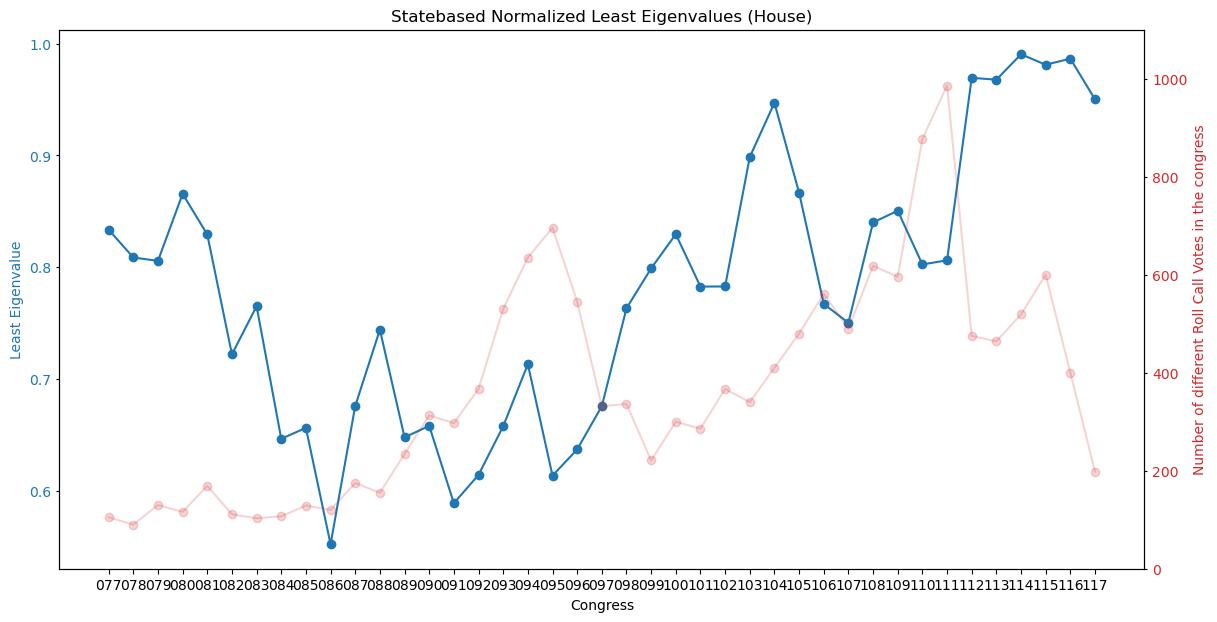

In [144]:
# plot the eigenvalues sorting the dictionary by key
congress_list_house = sorted(eig_dic_house.keys())
eigenvalue_list_house = [eig_dic_house[x] for x in congress_list_house]

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list_house, eigenvalue_list_house, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color, size=2)

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list_house = [n_votes_dic_house[x] for x in congress_list_house]
color = 'tab:red'
ax2.set_ylabel('Number of different Roll Call Votes in the congress', color=color)
ax2.plot(congress_list_house, n_votes_list_house, 'o-', color=color, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color, size=2)
ax2.set_ylim([0, 1100])

# set title
plt.title('Statebased Normalized Least Eigenvalues (House)')



Now do the same but for the senate

In [ ]:
# clean the folders
import shutil
#shutil.rmtree('../dataset/statebased_edgelsists_senate/*.csv')
#shutil.rmtree('../dataset/statebased_thresholds_senate/*.csv')

In [157]:
for csv in tqdm(glob.glob(senate_congress_path+'*.csv')):
    
    congress = pd.read_csv(csv)
    congress['state_abbrev'] = congress['icpsr'].map(members2state_dic)
    congress['code_district'] = congress['icpsr'].map(members2state_dic)
    congress['member_party_name'] = congress['icpsr'].map(members_party_dict)
    n_congress = re.findall(r'\d+', csv)[0]
    
    if not os.path.exists('../dataset/statebased_edgelsists_senate/edgelist_'+n_congress+'.csv'):
        edgelist = create_state_edgelist_from_congress(congress, frac)
        edgelist.to_csv('../dataset/statebased_edgelsists_senate/edgelist_'+n_congress+'.csv', index=False)
    else:
        edgelist = pd.read_csv('../dataset/statebased_edgelsists_senate/edgelist_'+n_congress+'.csv')
    
    if not os.path.exists('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv'):
        len_df = len(congress['bill_number'].unique())
        threshold_pos, area_pos = compute_threshold_intersx(edgelist, 1)
        threshold_neg, area_neg = compute_threshold_intersx(edgelist, -1)
        df_output = pd.DataFrame({
            'pos_threshold': [threshold_pos],
            'pos_area': [area_pos],
            'neg_threshold': [threshold_neg],
            'neg_area': [area_neg],
            'n_votes': [len_df]
        })
        df_output.to_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv', index=False)

100%|██████████| 41/41 [26:47<00:00, 39.21s/it]


In [146]:
# for each congress filter the edgelist with the threshold and save the normalized eigenvalue in a dictionary where the key is the congress number
eig_dic_senate = {}
n_votes_dic_senate = {}

for csv in tqdm(glob.glob('../dataset/statebased_edgelsists_senate/*.csv')):
    n_congress = re.findall(r'\d+', csv)[0]
    edgelist = pd.read_csv(csv)
    
    threshold_pos = pd.read_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv')['pos_threshold'][0]
    threshold_neg = pd.read_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv')['neg_threshold'][0]

    df_pos = edgelist.loc[(edgelist['weight']==1)&(edgelist['perc']>threshold_pos)].copy()
    df_neg = edgelist.loc[(edgelist['weight']==-1)&(edgelist['perc']>threshold_neg)].copy()
    edgelist_filtered = pd.concat([df_pos, df_neg])
    eig_dic_senate[n_congress] = compute_eigen(edgelist_filtered)
    n_votes = pd.read_csv('../dataset/statebased_thresholds_senate/threshold_'+n_congress+'.csv')['n_votes']
    n_votes_dic_senate[n_congress] = n_votes

100%|██████████| 41/41 [00:00<00:00, 49.92it/s]


Text(0.5, 1.0, 'Statebased Normalized Least Eigenvalues (Senate)')

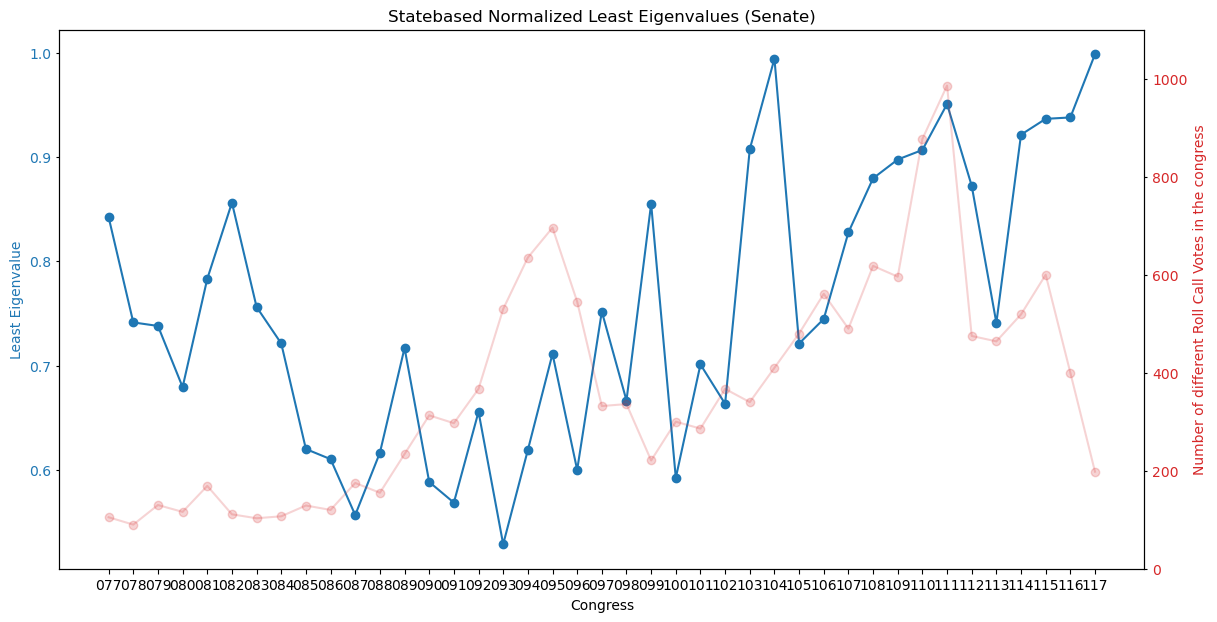

In [158]:
# plot the eigenvalues sorting the dictionary by key
congress_list_senate= sorted(eig_dic_senate.keys())
eigenvalue_list_senate = [eig_dic_senate[x] for x in congress_list_senate]

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Congress')
ax1.set_ylabel('Least Eigenvalue', color=color)
ax1.plot(congress_list_senate, eigenvalue_list_senate, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color, size=2)

# Create a second y-axis
ax2 = ax1.twinx()

n_votes_list_senate = [n_votes_dic_house[x] for x in congress_list_senate]
color = 'tab:red'
ax2.set_ylabel('Number of different Roll Call Votes in the congress', color=color)
ax2.plot(congress_list_house, n_votes_list_senate, 'o-', color=color, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color, size=2)
ax2.set_ylim([0, 1100])

# set title
plt.title('Statebased Normalized Least Eigenvalues (Senate)')